## Processing the ICF dataset to update the true and false analogue pairs with similarity metrics on the basis of structure, metabolism, alerts and physicochemical similarity.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
%matplotlib inline

In [3]:
TOP = os.getcwd().replace('notebooks', '')
raw_dir = TOP + 'data/raw/'
processed_dir = TOP + 'data/processed/'
interim_dir = TOP + 'data/interim/'
external_dir = TOP + 'data/external/'
figures_dir = TOP + 'reports/figures/'

### Processing information from Derek Nexus

In [5]:
derek_df = pd.read_csv(processed_dir+'Derek_nexus_290324.tsv', sep = '\t')

In [6]:
col_names = derek_df.columns.values


In [7]:
names_w_structure = len([a for a in col_names if "Structure" in a])
names_w_out_structure = [a for a in col_names if "Structure" not in a]
print(f'{names_w_structure} Contain substring "Structure" ')

print(f'{len(names_w_out_structure)} do NOT Contain substring "Structure" ')

316 Contain substring "Structure" 
263 do NOT Contain substring "Structure" 


In [8]:
derek_filtered = derek_df.copy()

In [9]:
a = set(derek_filtered.columns.values)
b = set(names_w_out_structure)
b-a


set()

In [10]:
derek_filtered_no_ec3 = derek_filtered.filter(regex='^(?!.*EC3)')

In [11]:
cols = derek_filtered_no_ec3.columns.tolist()

In [12]:
#cols

In [13]:
to_remove = cols[2:28]
derek_alerts_reasoning = derek_filtered_no_ec3.loc[:, ~derek_filtered_no_ec3.columns.isin(to_remove)].copy()

In [14]:
derek_alerts_reasoning = derek_alerts_reasoning.drop_duplicates(subset = 'Compound Name')

derek_temp = derek_alerts_reasoning.filter(regex='Compound Name|Alert \d name|reasoning$')
derek_temp = derek_temp.filter(regex='^(?!.*sensitisation)')
derek_temp = derek_temp.filter(regex='^(?!.*Tautomer)')

derek_temp = derek_temp.set_index('Compound Name')
derek_alert_names = derek_temp.filter(regex='Alert \d name')  #ALERT NAMES


In [15]:
my_names = []
for column in derek_alert_names:
    names = derek_alert_names[column].values
    clean_names = [name for name in names if not pd.isna(name)]
    my_names.append(clean_names)

my_names = sum(my_names,[])
my_names = list(set(my_names))
len(my_names)

85

In [16]:
endpoint_names = [i.split(' Alert')[0] for i in derek_temp.filter(regex='Alert \d').columns.values]
unique_endpoints = list(set(endpoint_names))
conditions_list = []
endpoint_list = []

for endpoint in unique_endpoints:
    derek_endpoint_cols = derek_temp.filter(like=f'{endpoint}').filter(regex='reasoning$|Alert \d')
    derek_reasoning = derek_endpoint_cols.filter(regex='reasoning$')
    derek_alerts = derek_endpoint_cols.filter(regex='Alert \d')
    temp_list = []
    for col in derek_alerts:
        alert = derek_alerts.filter(items=[col])
        temp = pd.concat([alert,derek_reasoning],axis=1)
        temp = temp.dropna(how='any').values.tolist()
        [x.insert(0,endpoint) for x in temp]
        temp = [list(x) for x in set(tuple(x) for x in temp)]  #ignore; Removed duplicates, dupes removed at end
        temp_list.append(pd.DataFrame(temp))
    endpoint_conditions = pd.concat(temp_list,axis=0).drop_duplicates().reset_index(drop=True)
    if len(endpoint_conditions) > 0:
        conditions_list.append(endpoint_conditions)
        endpoint_list.append(derek_endpoint_cols.T)
        

In [17]:
 tables = []
for i in range(0,len(endpoint_list)):
    conditions = conditions_list[i]
    endpoint = endpoint_list[i]
    tmp =  pd.concat([conditions,endpoint],axis=1)
    n_conditions = conditions.shape[0]

    for i in range(n_conditions):
        row_condition = tmp.iloc[i,1:3].values.tolist()
        row_vals = tmp.iloc[i,0:3].values.tolist()
        for col in tmp.iloc[:,3:]:
            col_values = tmp[col].values[n_conditions:].tolist()
            cond_row = tmp.iloc[i]
            if all(vals in col_values for vals in row_condition):
                row_vals.append(1)
            else:
                row_vals.append(0)
        tmp.iloc[i] = row_vals
    cond_table = tmp.head(conditions.shape[0])
    tables.append(cond_table)

In [18]:
final_table = pd.concat(tables)

In [19]:
final_table

,0,1,2,DTXSID4020298,DTXSID1020431,DTXSID6020430,DTXSID6022056,DTXSID0021965,DTXSID8026193,DTXSID8026195,...,DTXSID4024931,DTXSID8044965,DTXSID00885379,DTXSID2026238,DTXSID4027232,DTXSID3024366,DTXSID9026633,DTXSID4026761,DTXSID3029609,DTXSID8029608
0,Testicular toxicity mammal,"Monothioglycol or glycol monoalkyl ether, alko...",PLAUSIBLE,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
0,Skin irritation/corrosion mammal Structure 1,Hydrogen halide,PROBABLE,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
0,Kidney function-related toxicity mammal,Ticrynafen-like,EQUIVOCAL,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
0,Developmental toxicity mammal,"Monothioglycol or glycol monoalkyl ether, alko...",PLAUSIBLE,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
0,Ocular toxicity mammal,Phosphodiesterase 6 inhibitor,PLAUSIBLE,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2,Mitochondrial dysfunction mammal,Halogenated hydrocarbon,EQUIVOCAL,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,Mitochondrial dysfunction mammal,Phenol,EQUIVOCAL,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
0,Thyroid toxicity mammal,Thiocyanate salt,PLAUSIBLE,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,Thyroid toxicity mammal,Resorcinol or 3-aminophenol,PLAUSIBLE,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [20]:
final_table.rename(columns = {0: 'endpoint', 1: 'toxicophore', 2: 'confidence'}, inplace = True)

In [21]:
final_table

,endpoint,toxicophore,confidence,DTXSID4020298,DTXSID1020431,DTXSID6020430,DTXSID6022056,DTXSID0021965,DTXSID8026193,DTXSID8026195,...,DTXSID4024931,DTXSID8044965,DTXSID00885379,DTXSID2026238,DTXSID4027232,DTXSID3024366,DTXSID9026633,DTXSID4026761,DTXSID3029609,DTXSID8029608
0,Testicular toxicity mammal,"Monothioglycol or glycol monoalkyl ether, alko...",PLAUSIBLE,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
0,Skin irritation/corrosion mammal Structure 1,Hydrogen halide,PROBABLE,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
0,Kidney function-related toxicity mammal,Ticrynafen-like,EQUIVOCAL,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
0,Developmental toxicity mammal,"Monothioglycol or glycol monoalkyl ether, alko...",PLAUSIBLE,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
0,Ocular toxicity mammal,Phosphodiesterase 6 inhibitor,PLAUSIBLE,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2,Mitochondrial dysfunction mammal,Halogenated hydrocarbon,EQUIVOCAL,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,Mitochondrial dysfunction mammal,Phenol,EQUIVOCAL,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
0,Thyroid toxicity mammal,Thiocyanate salt,PLAUSIBLE,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,Thyroid toxicity mammal,Resorcinol or 3-aminophenol,PLAUSIBLE,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [22]:
final_table['endpoint_revised'] = [e.split('Structure')[0]  for e in final_table['endpoint']]

In [23]:
final_table.drop(['endpoint'], axis = 1, inplace = True)

In [24]:
final_table = final_table.drop_duplicates()

In [25]:
final_table.groupby(['endpoint_revised', 'toxicophore']).count()

confidence  \
endpoint_revised                               toxicophore                                    
Bone marrow toxicity mammal                    1,2-Ethylene glycol                        1   
                                               Aniline or precursor                       1   
Carcinogenicity mammal                         Aromatic nitro compound                    1   
                                               Ethanolamine or aminoethanethiol           3   
Cholinesterase inhibition mammal               Organophosphorus ester                     1   
...                                                                                     ...   
Thyroid toxicity mammal                        Thiocyanate salt                           1   
Uncoupler of oxidative phosphorylation mammal  Polynitrophenol or precursor               1   
Urolithiasis mammal                            Ticrynafen-like                            1   
alpha-2-mu-Globulin nephropathy mammal         Isopentyl group                            1   
                                               Polyhalogenated benzene                    1   

                                                                                 DTXSID4020298  \
endpoint_revised                               toxicophore                                       
Bone marrow toxicity mammal                    1,2-Ethylene glycol                           1   
                                               Aniline or precursor                          1   
Carcinogenicity mammal                         Aromatic nitro compound                       1   
                                               Ethanolamine or aminoethanethiol              3   
Cholinesterase inhibition mammal               Organophosphorus ester                        1   
...                                                                                        ...   
Thyroid toxicity mammal                        Thiocyanate salt                              1   
Uncoupler of oxidative phosphorylation mammal  Polynitrophenol or precursor                  1   
Urolithiasis mammal                            Ticrynafen-like                               1   
alpha-2-mu-Globulin nephropathy mammal         Isopentyl group                               1   
                                               Polyhalogenated benzene                       1   

                                                                                 DTXSID1020431  \
endpoint_revised                               toxicophore                                       
Bone marrow toxicity mammal                    1,2-Ethylene glycol                           1   
                                               Aniline or precursor                          1   
Carcinogenicity mammal                         Aromatic nitro compound                       1   
                                               Ethanolamine or aminoethanethiol              3   
Cholinesterase inhibition mammal               Organophosphorus ester                        1   
...                                                                                        ...   
Thyroid toxicity mammal                        Thiocyanate salt                              1   
Uncoupler of oxidative phosphorylation mammal  Polynitrophenol or precursor                  1   
Urolithiasis mammal                            Ticrynafen-like                               1   
alpha-2-mu-Globulin nephropathy mammal         Isopentyl group                               1   
                                               Polyhalogenated benzene                       1   

                                                                                 DTXSID6020430  \
endpoint_revised                               toxicophore                                       
Bone marrow toxicity mammal                    1,2-Ethylene glycol                           1   
 

In [26]:
ft_copy = final_table.copy()

In [27]:
ft_copy

,toxicophore,confidence,DTXSID4020298,DTXSID1020431,DTXSID6020430,DTXSID6022056,DTXSID0021965,DTXSID8026193,DTXSID8026195,DTXSID1026089,...,DTXSID8044965,DTXSID00885379,DTXSID2026238,DTXSID4027232,DTXSID3024366,DTXSID9026633,DTXSID4026761,DTXSID3029609,DTXSID8029608,endpoint_revised
0,"Monothioglycol or glycol monoalkyl ether, alko...",PLAUSIBLE,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,Testicular toxicity mammal
0,Hydrogen halide,PROBABLE,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,Skin irritation/corrosion mammal
0,Ticrynafen-like,EQUIVOCAL,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,Kidney function-related toxicity mammal
0,"Monothioglycol or glycol monoalkyl ether, alko...",PLAUSIBLE,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,Developmental toxicity mammal
0,Phosphodiesterase 6 inhibitor,PLAUSIBLE,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,Ocular toxicity mammal
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2,Halogenated hydrocarbon,EQUIVOCAL,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,Mitochondrial dysfunction mammal
3,Phenol,EQUIVOCAL,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,Mitochondrial dysfunction mammal
0,Thiocyanate salt,PLAUSIBLE,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,Thyroid toxicity mammal
1,Resorcinol or 3-aminophenol,PLAUSIBLE,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,Thyroid toxicity mammal


In [28]:
ft_copy = ft_copy.drop(['confidence'], axis = 1)
ft_copy = ft_copy.groupby(['endpoint_revised', 'toxicophore']).agg(lambda x: x.sum())
ft_copy2 = ft_copy.T
# scipy
from scipy.spatial.distance import pdist, squareform
D_react = pd.DataFrame(squareform(pdist(ft_copy2, 'jaccard')), columns = ft_copy2.index, index = ft_copy2.index)
S_react = 1- D_react

In [41]:
ft_copy2.columns.unique()[0]

('Bone marrow toxicity mammal', '1,2-Ethylene glycol')

In [48]:
set([e[0] for e in ft_copy2.columns.unique()])

{'Bone marrow toxicity mammal',
 'Carcinogenicity mammal ',
 'Cholinesterase inhibition mammal',
 'Chromosome damage in vitro mammal ',
 'Chromosome damage in vivo mammal',
 'Developmental toxicity mammal',
 'Hepatotoxicity mammal ',
 'Irritation (of the eye) mammal ',
 'Irritation (of the gastrointestinal tract) mammal ',
 'Irritation (of the respiratory tract) mammal ',
 'Kidney function-related toxicity mammal',
 'Methaemoglobinaemia mammal ',
 'Mitochondrial dysfunction mammal',
 'Mutagenicity in vitro mammal',
 'Mutagenicity in vivo mammal',
 'Nephrotoxicity mammal',
 'Neurotoxicity mammal',
 'Non-specific genotoxicity in vitro mammal',
 'Ocular toxicity mammal',
 'Oestrogenicity mammal',
 'Phospholipidosis mammal',
 'Photoallergenicity mammal',
 'Skin irritation/corrosion mammal ',
 'Splenotoxicity mammal',
 'Teratogenicity mammal',
 'Testicular toxicity mammal',
 'Thyroid toxicity mammal',
 'Uncoupler of oxidative phosphorylation mammal ',
 'Urolithiasis mammal',
 'alpha-2-mu-Gl

In [29]:
S_react

,DTXSID4020298,DTXSID1020431,DTXSID6020430,DTXSID6022056,DTXSID0021965,DTXSID8026193,DTXSID8026195,DTXSID1026089,DTXSID6026088,DTXSID7024320,...,DTXSID4024931,DTXSID8044965,DTXSID00885379,DTXSID2026238,DTXSID4027232,DTXSID3024366,DTXSID9026633,DTXSID4026761,DTXSID3029609,DTXSID8029608
DTXSID4020298,1.0,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
DTXSID1020431,0.5,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
DTXSID6020430,0.5,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
DTXSID6022056,0.5,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
DTXSID0021965,0.5,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
DTXSID3024366,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0
DTXSID9026633,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
DTXSID4026761,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0
DTXSID3029609,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0


<Axes: >

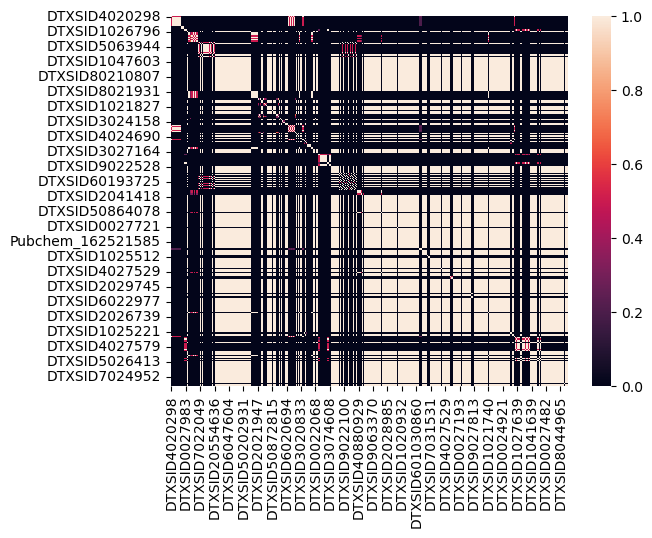

In [36]:
import seaborn as sns
sns.heatmap(S_react)

## Reading in the ICF processed examples to explore similarity in alert profile across cases

In [51]:
df1 = pd.read_csv(interim_dir+'icf_processed_110424.csv', index_col = [0])

In [66]:
mydict = {}
for i, group in df1.groupby('Index'):
    subset = list(group['DTXSID'])
    mydict[i] = subset

In [81]:
S_react.columns

Index(['DTXSID4020298', 'DTXSID1020431', 'DTXSID6020430', 'DTXSID6022056',
       'DTXSID0021965', 'DTXSID8026193', 'DTXSID8026195', 'DTXSID1026089',
       'DTXSID6026088', 'DTXSID7024320',
       ...
       'DTXSID4024931', 'DTXSID8044965', 'DTXSID00885379', 'DTXSID2026238',
       'DTXSID4027232', 'DTXSID3024366', 'DTXSID9026633', 'DTXSID4026761',
       'DTXSID3029609', 'DTXSID8029608'],
      dtype='object', length=468)

In [94]:
#mydict[1]
#scratch pad  
a = S_react.loc[['DTXSID4020298', 'DTXSID1020431', 'DTXSID6020430', 'DTXSID6022056',], ['DTXSID4020298', 'DTXSID1020431', 'DTXSID6020430', 'DTXSID6022056',]]
a1 = np.array(a)
mk = np.triu(np.ones_like(a), k=1)
b = a.where(mk == 1, np.nan).unstack().reset_index().dropna()
b2 = b[b['level_0'] != b['level_1']]
b2

,level_0,level_1,0
4,DTXSID1020431,DTXSID4020298,0.5
8,DTXSID6020430,DTXSID4020298,0.5
9,DTXSID6020430,DTXSID1020431,1.0
12,DTXSID6022056,DTXSID4020298,0.5
13,DTXSID6022056,DTXSID1020431,1.0
14,DTXSID6022056,DTXSID6020430,1.0


In [96]:
mydict2 = {}
for k,v in mydict.items():
    common_indices = np.intersect1d(v, S_react.index)
    # Filter S_react using common indices
    a = S_react.loc[common_indices, common_indices]
    mk = np.triu(np.ones_like(a), k=1)
    b = a.where(mk == 1, np.nan).unstack().reset_index().dropna()
    b2 = b[b['level_0'] != b['level_1']]
    b3 = b2[0].to_numpy()
    mydict2[k] = b3

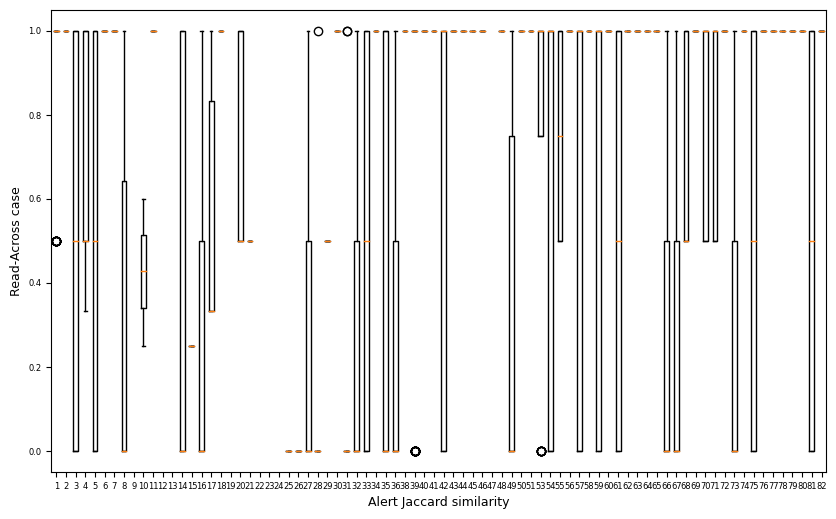

In [123]:
keys = list(mydict2.keys())
values = list(mydict2.values())

# Create a boxplot
plt.figure(figsize=(10, 6))
plt.boxplot(values, labels=keys)
plt.xlabel('Alert Jaccard similarity', fontsize=9)
plt.ylabel('Read-Across case',fontsize=9)
plt.xticks(fontsize=6)  # X-axis tick labels
plt.yticks(fontsize=6)
plt.savefig(figures_dir+'Alert_similarity.png', dpi = 300);  # Y-axis tick labels

In [124]:
from sklearn.preprocessing import MinMaxScaler

In [127]:
opera_df = pd.read_csv(processed_dir+'ICF_RA_290324-sdf_OPERA2.9Pred.csv')


In [128]:
opera_df = opera_df[['MoleculeID','MolWeight','nbHBdAcc',
 'ndHBdDon','LogP_pred',]]

In [129]:
opera_df = opera_df.set_index('MoleculeID')

In [130]:
physchem = opera_df.copy()

In [131]:
scaler= MinMaxScaler()

In [132]:
physchem2 = pd.DataFrame(scaler.fit_transform(physchem), columns = ['MolWeight', 'nbHBdAcc', 'ndHBdDon', 'LogP_pred'],) 

In [133]:
def distance_matrix_euclidean(df):
    '''
    Function to create a pairwise square distance matrix using the Jaccard index
    '''
    D_phys = pd.DataFrame(squareform(pdist(df, 'euclidean')), columns = df.index, index = df.index)

    return D_phys


In [134]:
S_physchem = 1- (distance_matrix_euclidean(physchem2))
S_physchem

,0,1,2,3,4,5,6,7,8,9,...,676,677,678,679,680,681,682,683,684,685
0,1.000000,0.940205,0.940694,0.935615,0.881873,0.877422,0.871757,0.820122,0.821594,0.819628,...,0.900258,0.782300,0.821087,0.872796,0.900258,0.798004,0.798004,0.798004,0.840982,0.920045
1,0.940205,1.000000,0.999288,0.993594,0.941658,0.937180,0.931292,0.879917,0.881388,0.879422,...,0.870186,0.730429,0.770725,0.828998,0.870186,0.745710,0.745710,0.745710,0.790334,0.900055
2,0.940694,0.999288,1.000000,0.992883,0.941178,0.936662,0.930737,0.879422,0.880900,0.878925,...,0.870743,0.731045,0.771330,0.829587,0.870743,0.746312,0.746312,0.746312,0.790913,0.900235
3,0.935615,0.993594,0.992883,1.000000,0.945748,0.941658,0.936141,0.884267,0.885674,0.883793,...,0.865105,0.724863,0.765252,0.823656,0.865105,0.740273,0.740273,0.740273,0.785083,0.898224
4,0.881873,0.941658,0.941178,0.945748,1.000000,0.993594,0.985765,0.938205,0.939711,0.937695,...,0.825933,0.677625,0.718449,0.779371,0.825933,0.692452,0.692452,0.692452,0.737545,0.856978
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
681,0.798004,0.745710,0.746312,0.740273,0.692452,0.687139,0.680591,0.633582,0.635318,0.633002,...,0.856637,0.981448,0.972350,0.908429,0.856637,1.000000,1.000000,1.000000,0.952397,0.803246
682,0.798004,0.745710,0.746312,0.740273,0.692452,0.687139,0.680591,0.633582,0.635318,0.633002,...,0.856637,0.981448,0.972350,0.908429,0.856637,1.000000,1.000000,1.000000,0.952397,0.803246
683,0.798004,0.745710,0.746312,0.740273,0.692452,0.687139,0.680591,0.633582,0.635318,0.633002,...,0.856637,0.981448,0.972350,0.908429,0.856637,1.000000,1.000000,1.000000,0.952397,0.803246
684,0.840982,0.790334,0.790913,0.785083,0.737545,0.732393,0.726024,0.678877,0.680563,0.678313,...,0.901569,0.935220,0.975765,0.952862,0.901569,0.952397,0.952397,0.952397,1.000000,0.850478


In [135]:
S_physchem.index = physchem.index
S_physchem.columns = physchem.index
S_physchem

MoleculeID,DTXSID4020298,DTXSID1020431,DTXSID6020430,DTXSID6022056,DTXSID0021965,DTXSID8026193,DTXSID8026195,DTXSID1026089,DTXSID6026088,DTXSID7024320,...,DTXSID9026633,DTXSID2026238,DTXSID4027232,DTXSID3024366,DTXSID9026633,DTXSID4026761,DTXSID4026761,DTXSID4026761,DTXSID3029609,DTXSID8029608
MoleculeID,,,,,,,,,,,,,,,,,,,,,
DTXSID4020298,1.000000,0.940205,0.940694,0.935615,0.881873,0.877422,0.871757,0.820122,0.821594,0.819628,...,0.900258,0.782300,0.821087,0.872796,0.900258,0.798004,0.798004,0.798004,0.840982,0.920045
DTXSID1020431,0.940205,1.000000,0.999288,0.993594,0.941658,0.937180,0.931292,0.879917,0.881388,0.879422,...,0.870186,0.730429,0.770725,0.828998,0.870186,0.745710,0.745710,0.745710,0.790334,0.900055
DTXSID6020430,0.940694,0.999288,1.000000,0.992883,0.941178,0.936662,0.930737,0.879422,0.880900,0.878925,...,0.870743,0.731045,0.771330,0.829587,0.870743,0.746312,0.746312,0.746312,0.790913,0.900235
DTXSID6022056,0.935615,0.993594,0.992883,1.000000,0.945748,0.941658,0.936141,0.884267,0.885674,0.883793,...,0.865105,0.724863,0.765252,0.823656,0.865105,0.740273,0.740273,0.740273,0.785083,0.898224
DTXSID0021965,0.881873,0.941658,0.941178,0.945748,1.000000,0.993594,0.985765,0.938205,0.939711,0.937695,...,0.825933,0.677625,0.718449,0.779371,0.825933,0.692452,0.692452,0.692452,0.737545,0.856978
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
DTXSID4026761,0.798004,0.745710,0.746312,0.740273,0.692452,0.687139,0.680591,0.633582,0.635318,0.633002,...,0.856637,0.981448,0.972350,0.908429,0.856637,1.000000,1.000000,1.000000,0.952397,0.803246
DTXSID4026761,0.798004,0.745710,0.746312,0.740273,0.692452,0.687139,0.680591,0.633582,0.635318,0.633002,...,0.856637,0.981448,0.972350,0.908429,0.856637,1.000000,1.000000,1.000000,0.952397,0.803246
DTXSID4026761,0.798004,0.745710,0.746312,0.740273,0.692452,0.687139,0.680591,0.633582,0.635318,0.633002,...,0.856637,0.981448,0.972350,0.908429,0.856637,1.000000,1.000000,1.000000,0.952397,0.803246


In [136]:
S_physchem.index.name = None

In [137]:
S_physchem.columns.name = None

In [138]:
S_physchem 

,DTXSID4020298,DTXSID1020431,DTXSID6020430,DTXSID6022056,DTXSID0021965,DTXSID8026193,DTXSID8026195,DTXSID1026089,DTXSID6026088,DTXSID7024320,...,DTXSID9026633,DTXSID2026238,DTXSID4027232,DTXSID3024366,DTXSID9026633,DTXSID4026761,DTXSID4026761,DTXSID4026761,DTXSID3029609,DTXSID8029608
DTXSID4020298,1.000000,0.940205,0.940694,0.935615,0.881873,0.877422,0.871757,0.820122,0.821594,0.819628,...,0.900258,0.782300,0.821087,0.872796,0.900258,0.798004,0.798004,0.798004,0.840982,0.920045
DTXSID1020431,0.940205,1.000000,0.999288,0.993594,0.941658,0.937180,0.931292,0.879917,0.881388,0.879422,...,0.870186,0.730429,0.770725,0.828998,0.870186,0.745710,0.745710,0.745710,0.790334,0.900055
DTXSID6020430,0.940694,0.999288,1.000000,0.992883,0.941178,0.936662,0.930737,0.879422,0.880900,0.878925,...,0.870743,0.731045,0.771330,0.829587,0.870743,0.746312,0.746312,0.746312,0.790913,0.900235
DTXSID6022056,0.935615,0.993594,0.992883,1.000000,0.945748,0.941658,0.936141,0.884267,0.885674,0.883793,...,0.865105,0.724863,0.765252,0.823656,0.865105,0.740273,0.740273,0.740273,0.785083,0.898224
DTXSID0021965,0.881873,0.941658,0.941178,0.945748,1.000000,0.993594,0.985765,0.938205,0.939711,0.937695,...,0.825933,0.677625,0.718449,0.779371,0.825933,0.692452,0.692452,0.692452,0.737545,0.856978
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
DTXSID4026761,0.798004,0.745710,0.746312,0.740273,0.692452,0.687139,0.680591,0.633582,0.635318,0.633002,...,0.856637,0.981448,0.972350,0.908429,0.856637,1.000000,1.000000,1.000000,0.952397,0.803246
DTXSID4026761,0.798004,0.745710,0.746312,0.740273,0.692452,0.687139,0.680591,0.633582,0.635318,0.633002,...,0.856637,0.981448,0.972350,0.908429,0.856637,1.000000,1.000000,1.000000,0.952397,0.803246
DTXSID4026761,0.798004,0.745710,0.746312,0.740273,0.692452,0.687139,0.680591,0.633582,0.635318,0.633002,...,0.856637,0.981448,0.972350,0.908429,0.856637,1.000000,1.000000,1.000000,0.952397,0.803246
DTXSID3029609,0.840982,0.790334,0.790913,0.785083,0.737545,0.732393,0.726024,0.678877,0.680563,0.678313,...,0.901569,0.935220,0.975765,0.952862,0.901569,0.952397,0.952397,0.952397,1.000000,0.850478


In [139]:
physdict = {}
for k,v in mydict.items():
    common_indices = np.intersect1d(v, S_physchem.index)
    # Filter S_react using common indices
    a = S_react.loc[common_indices, common_indices]
    mk = np.triu(np.ones_like(a), k=1)
    b = a.where(mk == 1, np.nan).unstack().reset_index().dropna()
    b2 = b[b['level_0'] != b['level_1']]
    b3 = b2[0].to_numpy()
    physdict[k] = b3

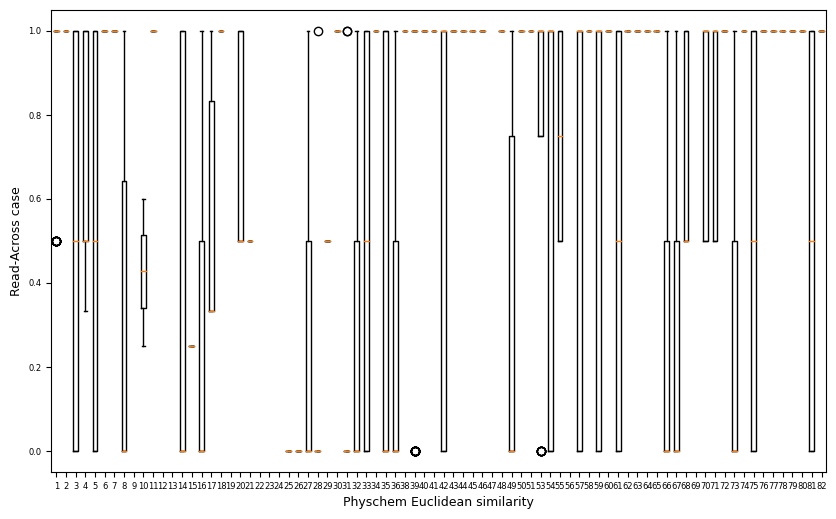

In [140]:
keys = list(physdict.keys())
values = list(physdict.values())

# Create a boxplot
plt.figure(figsize=(10, 6))
plt.boxplot(values, labels=keys)
plt.xlabel('Physchem Euclidean similarity', fontsize=9)
plt.ylabel('Read-Across case',fontsize=9)
plt.xticks(fontsize=6)  # X-axis tick labels
plt.yticks(fontsize=6)
plt.savefig(figures_dir+'Physchem_similarity.png', dpi = 300);  # Y-axis tick labels

In [76]:
icf_df = pd.read_csv('icf_rax_pairs.csv', index_col = [0])

In [77]:
icf_df = icf_df[['Target', 'Analogue', 'Label', 'analogue_smi', 'target_smi','tanimoto']]

In [71]:
wl = pd.read_csv('WL_TIMES_290324.csv', index_col = [0])

In [113]:
wl.shape

(468, 468)

In [73]:
Strans = pd.read_csv('Stransformations_290324.csv', index_col = [0])

In [114]:
Strans.shape

(468, 468)

In [74]:
Smetab = pd.read_csv('Smetabolites_290324.csv', index_col = [0])

In [116]:
Smetab.shape

(468, 468)

In [85]:
S_physchem.loc['DTXSID4052059','DTXSID8021931' ]

0.5540847147547996

In [151]:

S_physchem1 = S_physchem[~S_physchem.index.duplicated(keep='first')] 

In [152]:
S_physchem1

,DTXSID4020298,DTXSID1020431,DTXSID6020430,DTXSID6022056,DTXSID0021965,DTXSID8026193,DTXSID8026195,DTXSID1026089,DTXSID6026088,DTXSID7024320,...,DTXSID9026633,DTXSID2026238,DTXSID4027232,DTXSID3024366,DTXSID9026633,DTXSID4026761,DTXSID4026761,DTXSID4026761,DTXSID3029609,DTXSID8029608
DTXSID4020298,1.000000,0.940205,0.940694,0.935615,0.881873,0.877422,0.871757,0.820122,0.821594,0.819628,...,0.900258,0.782300,0.821087,0.872796,0.900258,0.798004,0.798004,0.798004,0.840982,0.920045
DTXSID1020431,0.940205,1.000000,0.999288,0.993594,0.941658,0.937180,0.931292,0.879917,0.881388,0.879422,...,0.870186,0.730429,0.770725,0.828998,0.870186,0.745710,0.745710,0.745710,0.790334,0.900055
DTXSID6020430,0.940694,0.999288,1.000000,0.992883,0.941178,0.936662,0.930737,0.879422,0.880900,0.878925,...,0.870743,0.731045,0.771330,0.829587,0.870743,0.746312,0.746312,0.746312,0.790913,0.900235
DTXSID6022056,0.935615,0.993594,0.992883,1.000000,0.945748,0.941658,0.936141,0.884267,0.885674,0.883793,...,0.865105,0.724863,0.765252,0.823656,0.865105,0.740273,0.740273,0.740273,0.785083,0.898224
DTXSID0021965,0.881873,0.941658,0.941178,0.945748,1.000000,0.993594,0.985765,0.938205,0.939711,0.937695,...,0.825933,0.677625,0.718449,0.779371,0.825933,0.692452,0.692452,0.692452,0.737545,0.856978
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
DTXSID3024366,0.872796,0.828998,0.829587,0.823656,0.779371,0.774093,0.767564,0.722266,0.723992,0.721689,...,0.948166,0.893705,0.935778,1.000000,0.948166,0.908429,0.908429,0.908429,0.952862,0.883978
DTXSID9026633,0.900258,0.870186,0.870743,0.865105,0.825933,0.820707,0.814220,0.771147,0.772870,0.770571,...,1.000000,0.842348,0.884099,0.948166,1.000000,0.856637,0.856637,0.856637,0.901569,0.916413
DTXSID4026761,0.798004,0.745710,0.746312,0.740273,0.692452,0.687139,0.680591,0.633582,0.635318,0.633002,...,0.856637,0.981448,0.972350,0.908429,0.856637,1.000000,1.000000,1.000000,0.952397,0.803246
DTXSID3029609,0.840982,0.790334,0.790913,0.785083,0.737545,0.732393,0.726024,0.678877,0.680563,0.678313,...,0.901569,0.935220,0.975765,0.952862,0.901569,0.952397,0.952397,0.952397,1.000000,0.850478


In [153]:

S_physchem2 = S_physchem1.loc[:,~S_physchem1.columns.duplicated()].copy()

In [154]:
S_physchem2.shape

(458, 458)

In [201]:
def analogue_pair(df, S, label = None):
    mylst = []
    for i, row in df.iterrows():
        a, b = row['Target'], row['Analogue']
        if (a and b) in S.index:
            c = S.loc[a,b]
            mylst.append([a,b,c])
            df = pd.DataFrame(mylst, columns = ['target', 'analogue', label])
    return df
    
        

In [165]:
test = analogue_pair(df = icf_df.head(), S = S_physchem2, label = 'Spchem')

In [166]:
test

,target,analogue,Spchem
0,DTXSID4052059,DTXSID8021931,0.554085
1,DTXSID4052059,DTXSID8021519,0.537737
2,DTXSID4052059,DTXSID50890812,0.482764
3,DTXSID4052059,DTXSID40337923,0.756080
4,DTXSID4052059,DTXSID3027370,0.515376


In [173]:
derek_aps = analogue_pair(df = icf_df, S = S_react, label = 'S_react')

In [175]:

#derek_aps

In [176]:
metabs_aps = analogue_pair(df = icf_df, S = Smetab, label = 'S_metabs')

In [177]:
metabs_aps

,target,analogue,S_metabs
0,DTXSID4052059,DTXSID8021931,0.0
1,DTXSID4052059,DTXSID8021519,0.0
2,DTXSID4052059,DTXSID50890812,0.0
3,DTXSID4052059,DTXSID40337923,0.0
4,DTXSID4052059,DTXSID3027370,0.0
...,...,...,...
109273,DTXSID601030860,DTXSID00862266,0.0
109274,DTXSID601030860,DTXSID50560285,0.0
109275,DTXSID6022008,DTXSID00862266,0.0
109276,DTXSID6022008,DTXSID50560285,0.0


In [178]:
trans_aps = analogue_pair(df = icf_df, S = Strans, label = 'S_trans')

In [181]:
trans_aps

,target,analogue,S_trans
0,DTXSID4052059,DTXSID8021931,0.0
1,DTXSID4052059,DTXSID8021519,0.0
2,DTXSID4052059,DTXSID50890812,0.0
3,DTXSID4052059,DTXSID40337923,0.0
4,DTXSID4052059,DTXSID3027370,0.0
...,...,...,...
109273,DTXSID601030860,DTXSID00862266,0.0
109274,DTXSID601030860,DTXSID50560285,0.0
109275,DTXSID6022008,DTXSID00862266,0.0
109276,DTXSID6022008,DTXSID50560285,0.0


In [179]:


wl_aps = analogue_pair(df = icf_df, S = wl, label = 'S_wl')


In [180]:
wl_aps

,target,analogue,S_wl
0,DTXSID4052059,DTXSID8021931,0.0
1,DTXSID4052059,DTXSID8021519,0.0
2,DTXSID4052059,DTXSID50890812,0.0
3,DTXSID4052059,DTXSID40337923,0.0
4,DTXSID4052059,DTXSID3027370,0.0
...,...,...,...
109273,DTXSID601030860,DTXSID00862266,0.0
109274,DTXSID601030860,DTXSID50560285,0.0
109275,DTXSID6022008,DTXSID00862266,0.0
109276,DTXSID6022008,DTXSID50560285,0.0


In [187]:
temp = pd.merge(icf_df, wl_aps, left_on = ['Target', 'Analogue'], right_on = ['target', 'analogue'], how = 'left')

In [189]:
temp.drop(['target','analogue'], axis =1, inplace = True)

In [191]:
temp2 = pd.merge(temp, trans_aps, left_on = ['Target', 'Analogue'], right_on = ['target', 'analogue'], how = 'left')

In [193]:
temp2.drop(['target','analogue'], axis =1, inplace = True)

In [194]:
temp2 = pd.merge(temp2, metabs_aps, left_on = ['Target', 'Analogue'], right_on = ['target', 'analogue'], how = 'left')



In [195]:
temp2.drop(['target','analogue'], axis =1, inplace = True)

In [197]:
temp2 = pd.merge(temp2, derek_aps, left_on = ['Target', 'Analogue'], right_on = ['target', 'analogue'], how = 'left')


In [198]:
temp2.drop(['target','analogue'], axis =1, inplace = True)

In [200]:
temp2.to_csv('sims_010424.csv')

In [254]:
def analogue_pair2(df, S, label = None):
    idx = df['Target'].unique().tolist() + df['Analogue'].unique().tolist()
    common_idx = [e for e in S.index.tolist() if e in idx]
    mylst = []
    for i, row in df.iterrows():
        a, b = row['Target'], row['Analogue']
        if (a and b) in common_idx:
            try:
                c = S.loc[a,b]
            except Exception as error:
                pass
            finally:
                mylst.append([a,b,c])
                df2 = pd.DataFrame(mylst, columns = ['target', 'analogue', label])
    return df2  

In [252]:
def analogue_pair(df, S, label = None):
    mylst = []
    for i, row in df.iterrows():
        a, b = row['Target'], row['Analogue']
        if (a or b) in S.index:
            c = S.loc[a,b]
            mylst.append([a,b,c])
            df = pd.DataFrame(mylst, columns = ['target', 'analogue', label])
    return df
    

In [255]:
physchem = analogue_pair2(df = icf_df, S = S_physchem2, label = 'Spchem')

In [256]:
physchem


,target,analogue,Spchem
0,DTXSID4052059,DTXSID8021931,0.554085
1,DTXSID4052059,DTXSID8021519,0.537737
2,DTXSID4052059,DTXSID50890812,0.482764
3,DTXSID4052059,DTXSID40337923,0.756080
4,DTXSID4052059,DTXSID3027370,0.515376
...,...,...,...
106872,DTXSID601030860,DTXSID00862266,0.938125
106873,DTXSID601030860,DTXSID50560285,0.672377
106874,DTXSID6022008,DTXSID00862266,0.765604
106875,DTXSID6022008,DTXSID50560285,0.845811


In [258]:
temp3 = pd.merge(temp2, physchem, left_on = ['Target', 'Analogue'], right_on = ['target', 'analogue'], how = 'left')

In [260]:
temp3.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 109278 entries, 0 to 109277
Data columns (total 13 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   Target        109278 non-null  object 
 1   Analogue      109278 non-null  object 
 2   Label         109278 non-null  int64  
 3   analogue_smi  109278 non-null  object 
 4   target_smi    109278 non-null  object 
 5   tanimoto      109278 non-null  float64
 6   S_wl          109278 non-null  float64
 7   S_trans       109278 non-null  float64
 8   S_metabs      109278 non-null  float64
 9   S_react       109278 non-null  float64
 10  target        106877 non-null  object 
 11  analogue      106877 non-null  object 
 12  Spchem        104602 non-null  float64
dtypes: float64(6), int64(1), object(6)
memory usage: 10.8+ MB


In [261]:
temp3.to_csv('sims_all_020424.csv')

<Axes: >

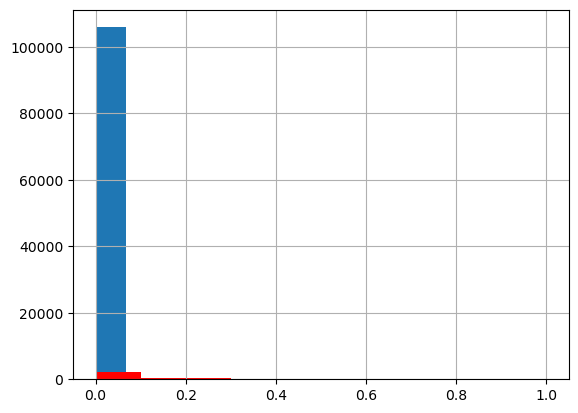

In [266]:
temp3[temp3['Label'] == 1]['S_metabs'].hist()
temp3[temp3['Label'] == 0]['S_metabs'].hist(color = 'r')

In [270]:
temp3[temp3['Spchem'].notnull()].to_csv('sims_notnull_020424.csv')